## Analysis of a ribosome profiling data using a transcriptome assembly as a reference

This analysis aims to predict novel translational events beyound protein-coding regions. However, gene annotation files from NCBI RefSeq/GenBank lack the transcription start and termination sites. To tackle this problem, we have performed _de novo_ metatranscriptome assembly using Nanopore long-read direct-RNA and Illumina short-read data [PRJNA609733](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA609733) for _Escherichia coli_ O157:H7 (ATCC 43895), _Salmonella enterica_ serovar Enteritidis (ATCC 13076), and _Listeria monocytogenes_ (ATCC 19115). We have assembled a separate _Salmonella enterica_ transcriptome using Nanopore long-read cDNA sequencing data [SRX20554650](https://www.ncbi.nlm.nih.gov/sra/SRX20554650). For ribosome profiling, we have analysed a highly phased ribosome profiling data [PRJEB51486](https://www.ebi.ac.uk/ena/browser/view/PRJEB51486) for _Salmonella enterica_ serovar Typhimurium.

### Download genomes and annotations
Follow README to create conda environment and clone the RIBOSS repository if you haven't already done so.
```
cd riboss
```

```
mkdir -p ref
cd ref

# Escherichia coli O157:H7 (ATCC 43895)
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/732/965/GCF_000732965.1_ASM73296v1/GCF_000732965.1_ASM73296v1_genomic.fna.gz
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/732/965/GCF_000732965.1_ASM73296v1/GCF_000732965.1_ASM73296v1_genomic.gff.gz

# Gram-positive Listeria monocytogenes 10403 S
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/168/695/GCF_000168695.2_ASM16869v2/GCF_000168695.2_ASM16869v2_genomic.fna.gz
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/168/695/GCF_000168695.2_ASM16869v2/GCF_000168695.2_ASM16869v2_genomic.gff.gz

# LT2
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.2_ASM694v2/GCF_000006945.2_ASM694v2_genomic.fna.gz
wget https://ftp.ncbi.nlm.nih.gov/genomes/all/GCF/000/006/945/GCF_000006945.2_ASM694v2/GCF_000006945.2_ASM694v2_genomic.gff.gz

# concatenate genomes and gene annotations
for i in *.fna.gz; do \
    zcat $i;
done > metagenome.fa

for i in *.gff.gz; do \
    zcat $i \
    | gff3ToGenePred stdin stdout \
    | genePredToBed stdin stdout
done > metagenome.bed
cd ..
```

#### Download ribosome profiling and RNA-seq data ([PRJEB51486](https://www.ebi.ac.uk/ena/browser/view/PRJEB51486))

```
mkdir -p doc/ doc/styphimurium/ doc/styphimurium/riboseq
cd doc/styphimurium/riboseq

wget "https://www.ebi.ac.uk/ena/portal/api/filereport?accession=PRJEB51486&result=read_run&fields=study_accession,sample_accession,secondary_sample_accession,experiment_accession,run_accession,tax_id,scientific_name,instrument_model,library_layout,library_strategy,library_source,fastq_ftp,submitted_ftp,sra_ftp,sample_alias,sample_title,bam_ftp&format=tsv&download=true&limit=0" -O filereport_read_run_PRJEB51486_tsv.txt

awk 'BEGIN{FS="\t"} NR>1 {print "wget -nc ftp://" $12}' filereport_read_run_PRJEB51486_tsv.txt | sh
```

#### Download Nanopore long-read direct RNA-seq and Illumina short-read RNA-seq data ([PRJNA609733](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA609733))

```
cd ../../
mkdir -p metatranscriptome
cd metatranscriptome

awk 'BEGIN{FS=","} NR>1 && !/SRR1124/ {print "prefetch",$1}' SraRunTable.csv | sh
awk 'BEGIN{FS=","} NR>1 && !/SRR1124/ {print "fasterq-dump",$1}' SraRunTable.csv | sh
gzip *.fastq

```

#### Align Nanopore long-read direct RNA-seq and Illumina short-read RNA-seq data ([PRJNA609733](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA609733))

```
# build index
cd ../../ref
bowtie2-build metagenome.fa metagenome
cd ..

# align short reads
for i in `ls doc/metatranscriptome/SRR1121566*.fastq.gz | sed 's/_/\t/' | awk '!seen[$1]++ {print $1}'`; do \
    bowtie2 \
    -p 8 \
    -x ref/metagenome \
    -1 ${i}_1.fastq.gz -2 ${i}_2.fastq.gz \
    --no-unal \
    -S ${i%%.*}.sam
done

# align long reads
for i in doc/metatranscriptome/SRR1121500*.fastq.gz; do \
    minimap2 -ax splice:hq -uf --sam-hit-only --MD \
    ref/metagenome.fa \
    $i > ${i%%.*}.sam
done

for i in doc/metatranscriptome/*.sam; do \
    samtools sort $i -o ${i%%.*}.bam
    samtools index ${i%%.*}.bam
    rm ${i%%.*}.sam
done
```

#### Download Nanopore cDNA sequencing data ([SRX20554650](https://www.ncbi.nlm.nih.gov/sra/SRX20554650))

```
mkdir -p doc/styphimurium/rnaseq/
cd doc/styphimurium/rnaseq/

prefetch SRR24781620
fasterq-dump SRR24781620
gzip SRR24781620.fastq
cd ../../../
```

#### Align Nanopore cDNA sequencing data ([SRX20554650](https://www.ncbi.nlm.nih.gov/sra/SRX20554650))

```
minimap2 -ax splice --sam-hit-only --MD ref/GCF_000006945.2_ASM694v2_genomic.fna.gz doc/styphimurium/rnaseq/SRR24781620.fastq.gz > doc/styphimurium/rnaseq/SRR24781620.sam
samtools sort doc/styphimurium/rnaseq/SRR24781620.sam -o doc/styphimurium/rnaseq/SRR24781620.bam
samtools index doc/styphimurium/rnaseq/SRR24781620.bam
```

#### Assemble transcriptome by combining Nanopore long-read direct RNA-seq and Illumina short-read RNA-seq data

In [1]:
import os
from glob import glob
from riboss.wrapper import transcriptome_assembly

superkingdom = 'Bacteria'
genome = 'ref/metagenome.fa'
strandness = 'rf'
long_reads = 'doc/metatranscriptome/SRR11215003.bam' 
short_reads = 'doc/metatranscriptome/SRR11215663.bam'

_, _ = transcriptome_assembly(superkingdom, genome, long_reads, short_reads, strandness, single_exon_coverage=1)

INFO:root:saved StringTie GTF as doc/metatranscriptome/SRR11215003.gtf
INFO:root:converted transcriptome assembly to doc/metatranscriptome/SRR11215003.bed
INFO:root:extracted sequences to doc/metatranscriptome/SRR11215003.transcripts.fa


In [2]:
long_reads = 'doc/metatranscriptome/SRR11215004.bam' 
short_reads = 'doc/metatranscriptome/SRR11215664.bam'

_, _ = transcriptome_assembly(superkingdom, genome, long_reads, short_reads, strandness, single_exon_coverage=1)

INFO:root:saved StringTie GTF as doc/metatranscriptome/SRR11215004.gtf
INFO:root:converted transcriptome assembly to doc/metatranscriptome/SRR11215004.bed
INFO:root:extracted sequences to doc/metatranscriptome/SRR11215004.transcripts.fa


In [3]:
long_reads = 'doc/styphimurium/rnaseq/SRR24781620.bam' 

_, _ = transcriptome_assembly(superkingdom, genome, long_reads, single_exon_coverage=1)

INFO:root:saved StringTie GTF as doc/styphimurium/rnaseq/SRR24781620.gtf
INFO:root:converted transcriptome assembly to doc/styphimurium/rnaseq/SRR24781620.bed
INFO:root:extracted sequences to doc/styphimurium/rnaseq/SRR24781620.transcripts.fa


#### Merge transcriptomes

In [4]:
! gunzip ref/GCF_000006945.2_ASM694v2_genomic.gff.gz

! stringtie -G ref/GCF_000006945.2_ASM694v2_genomic.gff \
--merge \
doc/metatranscriptome/SRR11215003.gtf doc/metatranscriptome/SRR11215004.gtf doc/styphimurium/rnaseq/SRR24781620.gtf \
| gtfToGenePred stdin stdout \
| genePredToBed stdin doc/metatranscriptome/metatranscriptome.bed

# extract LT2 assembled transcripts
! awk '/NC_003197.2|NC_003277.2/' doc/metatranscriptome/metatranscriptome.bed \
| cat <(echo 'track name="Transcriptome" description="Transcriptome assembly" visibility=2 colorByStrand="255,0,0 0,0,255"') - \
> doc/metatranscriptome/lt2.bed
! bedtools getfasta \
-bed doc/metatranscriptome/lt2.bed \
-fi ref/metagenome.fa -name \
-s -fo doc/metatranscriptome/lt2.fa

! grep -c ">" doc/metatranscriptome/lt2.fa

4692


#### Build STAR index for the newly assembled transcriptome

In [5]:
import os
from riboss.wrapper import build_star_index

tx_assembly = 'doc/metatranscriptome/lt2.fa'
index = tx_assembly.split(os.extsep)[0]

build_star_index(tx_assembly, index)

	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode genomeGenerate --runThreadN 4 --genomeDir doc/metatranscriptome/lt2 --genomeFastaFiles doc/metatranscriptome/lt2.fa --genomeSAindexNbases 7 --genomeChrBinNbits 11
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Nov 06 16:53:29 ..... started STAR run
Nov 06 16:53:29 ... starting to generate Genome files
Nov 06 16:53:29 ... starting to sort Suffix Array. This may take a long time...
Nov 06 16:53:29 ... sorting Suffix Array chunks and saving them to disk...
Nov 06 16:53:30 ... loading chunks from disk, packing SA...
Nov 06 16:53:30 ... finished generating suffix array
Nov 06 16:53:30 ... generating Suffix Array index
Nov 06 16:53:31 ... completed Suffix Array index
Nov 06 16:53:31 ... writing Genome to disk ...
Nov 06 16:53:31 ... writing Suffix Array to disk ...


INFO:root:saved index to doc/metatranscriptome/lt2


Nov 06 16:53:31 ... writing SAindex to disk
Nov 06 16:53:31 ..... finished successfully


#### Map ribosome footprints to transcriptome

In [6]:
from glob import glob
from riboss.wrapper import align_short_reads

for i in glob('doc/styphimurium/riboseq/*[0-9].fastq.gz'):
    prefix = i.split(os.extsep)[0]
    align_short_reads(i, prefix, index)

	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn doc/styphimurium/riboseq/ERR9130946.fastq.gz --outFileNamePrefix doc/styphimurium/riboseq/ERR9130946 --genomeDir doc/metatranscriptome/lt2 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Nov 06 16:53:37 ..... started STAR run
Nov 06 16:53:37 ..... loading genome
Nov 06 16:53:37 ..... started mapping


INFO:root:saved alignment to doc/styphimurium/riboseq/ERR9130946Aligned.out.bam


Nov 06 16:58:55 ..... finished mapping
Nov 06 16:58:55 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn doc/styphimurium/riboseq/ERR9130943.fastq.gz --outFileNamePrefix doc/styphimurium/riboseq/ERR9130943 --genomeDir doc/metatranscriptome/lt2 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Nov 06 16:58:55 ..... started STAR run
Nov 06 16:58:55 ..... loading genome
Nov 06 16:58:55 ..... started mapping


INFO:root:saved alignment to doc/styphimurium/riboseq/ERR9130943Aligned.out.bam


Nov 06 17:02:39 ..... finished mapping
Nov 06 17:02:39 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn doc/styphimurium/riboseq/ERR9130945.fastq.gz --outFileNamePrefix doc/styphimurium/riboseq/ERR9130945 --genomeDir doc/metatranscriptome/lt2 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Nov 06 17:02:39 ..... started STAR run
Nov 06 17:02:39 ..... loading genome
Nov 06 17:02:39 ..... started mapping


INFO:root:saved alignment to doc/styphimurium/riboseq/ERR9130945Aligned.out.bam


Nov 06 17:04:24 ..... finished mapping
Nov 06 17:04:24 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn doc/styphimurium/riboseq/ERR9130944.fastq.gz --outFileNamePrefix doc/styphimurium/riboseq/ERR9130944 --genomeDir doc/metatranscriptome/lt2 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Nov 06 17:04:24 ..... started STAR run
Nov 06 17:04:24 ..... loading genome
Nov 06 17:04:24 ..... started mapping


INFO:root:saved alignment to doc/styphimurium/riboseq/ERR9130944Aligned.out.bam


Nov 06 17:06:45 ..... finished mapping
Nov 06 17:06:45 ..... finished successfully
	/home/limch05p/miniforge3/envs/riboss/bin/STAR-avx2 --runMode alignReads --readFilesIn doc/styphimurium/riboseq/ERR9130942.fastq.gz --outFileNamePrefix doc/styphimurium/riboseq/ERR9130942 --genomeDir doc/metatranscriptome/lt2 --runThreadN 4 --readFilesCommand zcat --seedSearchLmax 10 --outFilterMultimapScoreRange 0 --outFilterMultimapNmax 255 --outFilterMismatchNmax 1 --outFilterIntronMotifs RemoveNoncanonical --outSAMtype BAM Unsorted --outSAMmode NoQS --outSAMattributes NH NM
	STAR version: 2.7.11b   compiled: 2024-07-03T14:39:20+0000 :/opt/conda/conda-bld/star_1720017372352/work/source
Nov 06 17:06:46 ..... started STAR run
Nov 06 17:06:46 ..... loading genome
Nov 06 17:06:46 ..... started mapping


INFO:root:saved alignment to doc/styphimurium/riboseq/ERR9130942Aligned.out.bam


Nov 06 17:08:26 ..... finished mapping
Nov 06 17:08:26 ..... finished successfully


#### Predict operons from transcriptome assembly

finding all ORFs       : 100%|██████████████| 4.69k/4.69k [00:06<00:00, 726it/s]
INFO:root:plotted the distribution of operons as results/operon_finder/lt2.operon_dist.pdf and results/operon_finder/lt2.operon_scatter.pdf
INFO:root:saved operons and ORFs as results/operon_finder/lt2.operon_finder.pkl.gz
INFO:root:saved CDS range as results/operon_finder/lt2.cds_range.txt


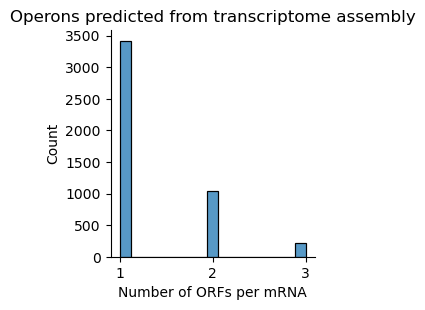

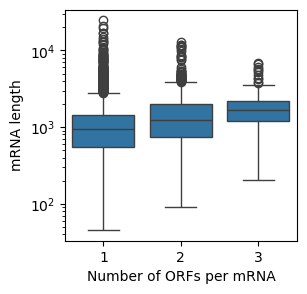

In [1]:
from riboss.orfs import operon_finder
import pyranges as pr
import pandas as pd

bed = 'ref/metagenome.bed'
outdir = 'results/operon_finder'
tx_assembly = 'doc/metatranscriptome/lt2.fa'
delim = '::'

op, cds_range, df = operon_finder(tx_assembly, bed, outdir, delim, log=True)

In [2]:
op.value_counts('count')

count
1    3418
2    1041
3     212
Name: count, dtype: int64

In [3]:
df.value_counts('ORF_type')

ORF_type
oORF     170763
sORF      78796
mORF       4548
opORF      1658
Name: count, dtype: int64

In [4]:
from riboss.orfs import fasta_to_dataframe

d = fasta_to_dataframe('doc/metatranscriptome/lt2.fa')
d['length'] = d.seq.apply(lambda x: len(x))
d.describe()

,length
count,4692.000000
mean,1358.039429
std,1423.819795
min,45.000000
25%,597.000000
50%,1015.000000
75%,1612.500000
max,24804.000000


#### Analyse ribosome footprints

analyse_footprints allows the aligned footprint positions to be adjusted to the P-site, either from the 5' or 3' end through the offset_method. For this data, the 5' offset method produced more consistent triplet periodicity for the footprint sizes 25 nt and 28 nt (see metagene plots).

downsampling BAM       : 9996680it [00:10, 919558.19it/s] 
comparing periodicity  : 100%|███████████████| 11.0/11.0 [00:03<00:00, 3.63it/s]
INFO:root:saved selected footprint sizes with an offset as results/analyse_footprints/ERR9130942Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as results/analyse_footprints/ERR9130942Aligned.out.frames.pdf
INFO:root:saved metagene plots as results/analyse_footprints/ERR9130942Aligned.out.start_codon.pdf and results/analyse_footprints/ERR9130942Aligned.out.stop_codon.pdf
downsampling BAM       : 24796997it [00:24, 1006941.20it/s]
comparing periodicity  : 100%|███████████████| 11.0/11.0 [00:07<00:00, 1.52it/s]
INFO:root:saved selected footprint sizes with an offset as results/analyse_footprints/ERR9130943Aligned.out.offset.txt
INFO:root:converted mapped frames into heatmaps as results/analyse_footprints/ERR9130943Aligned.out.frames.pdf
INFO:root:saved metagene plots as results/analyse_footprints/ERR9130943Aligned.out.start_cod

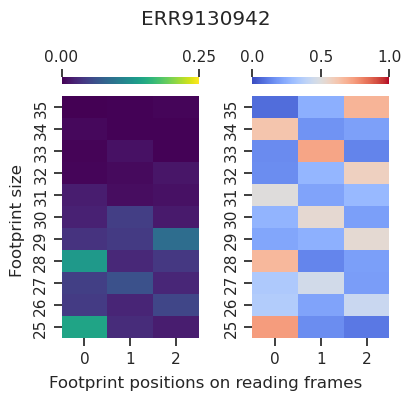

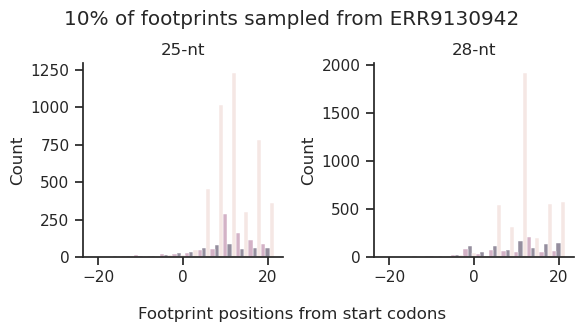

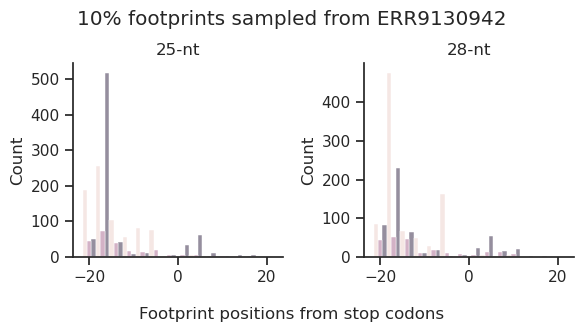

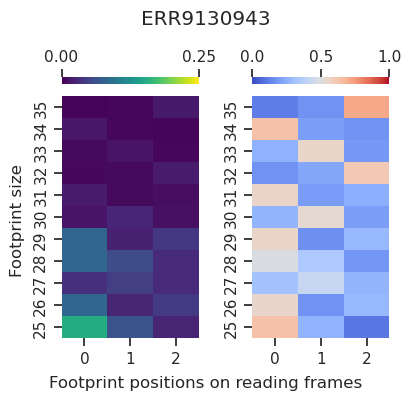

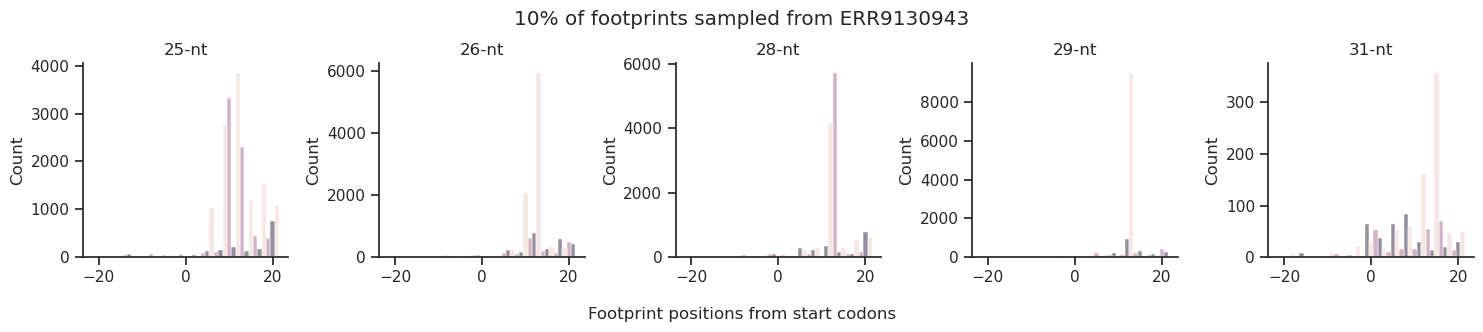

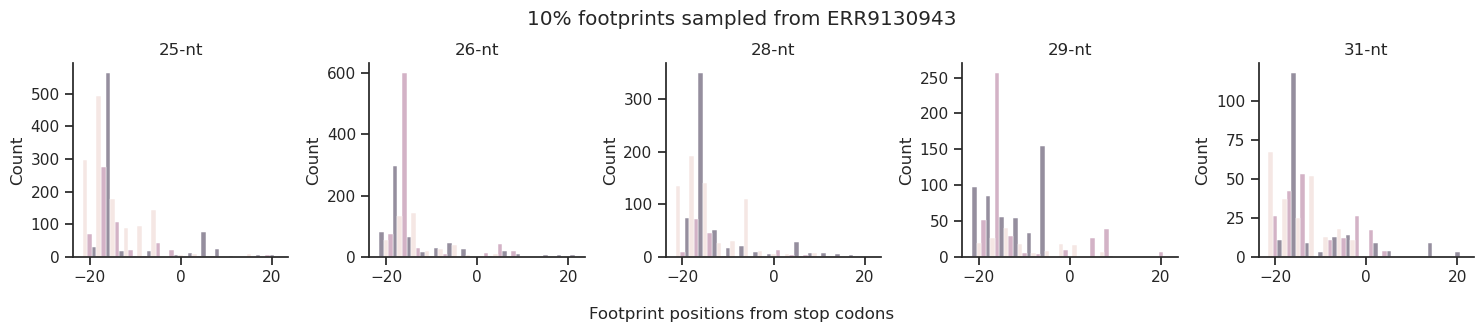

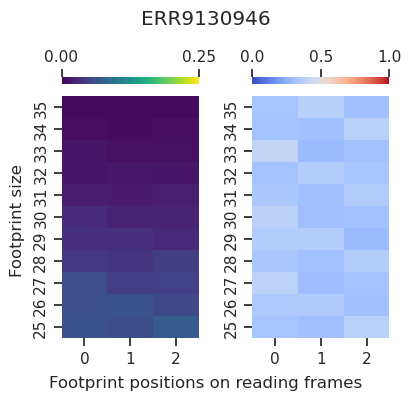

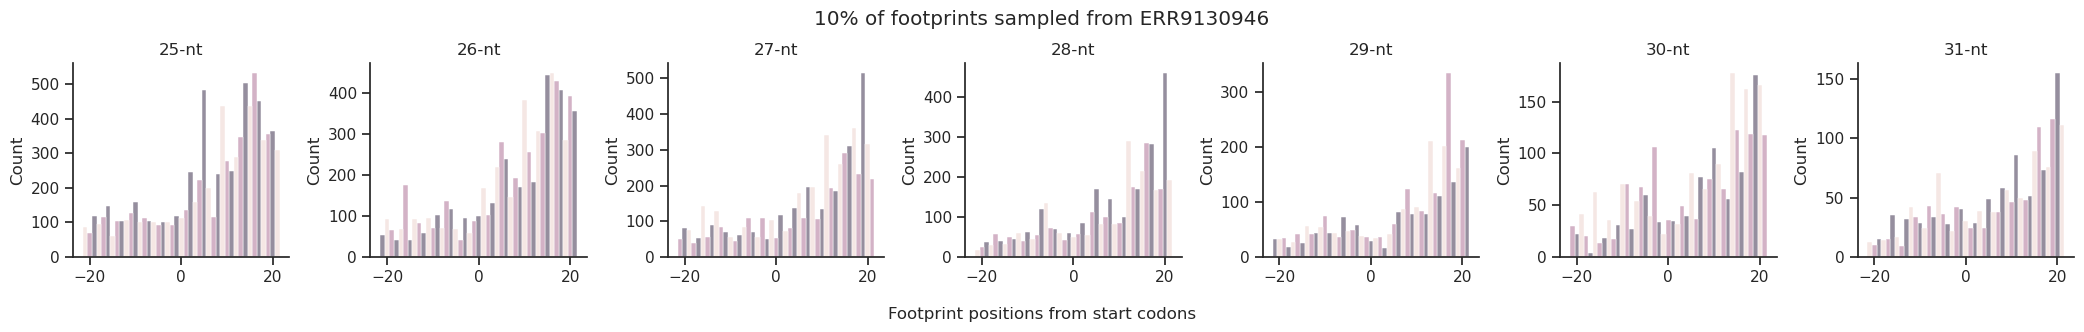

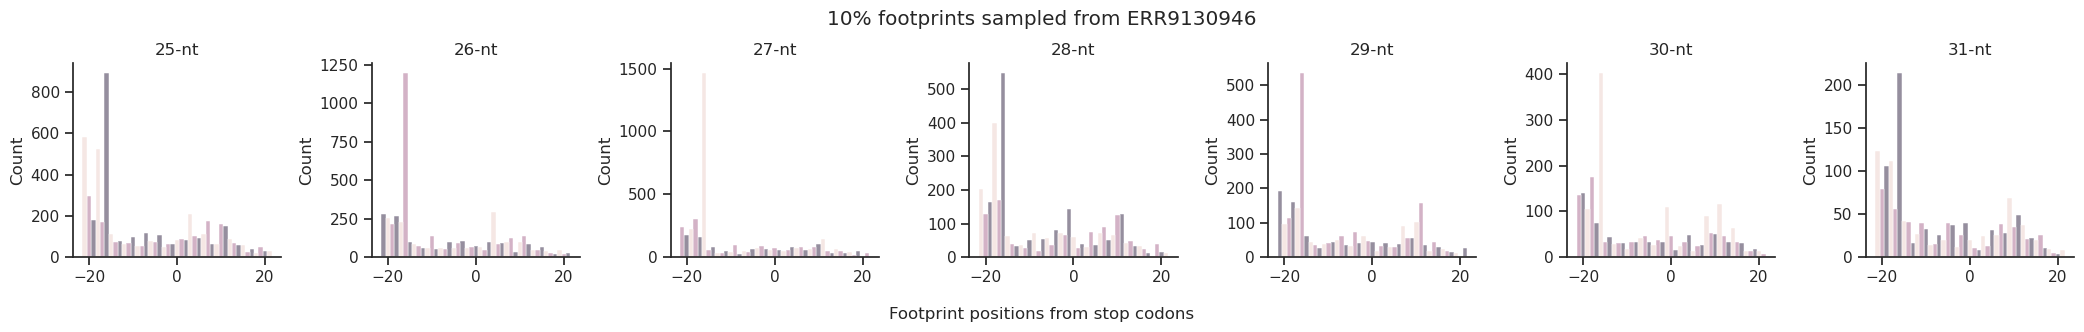

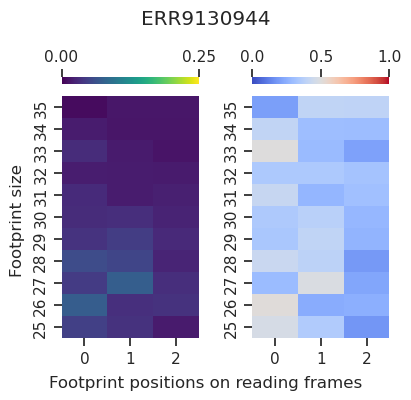

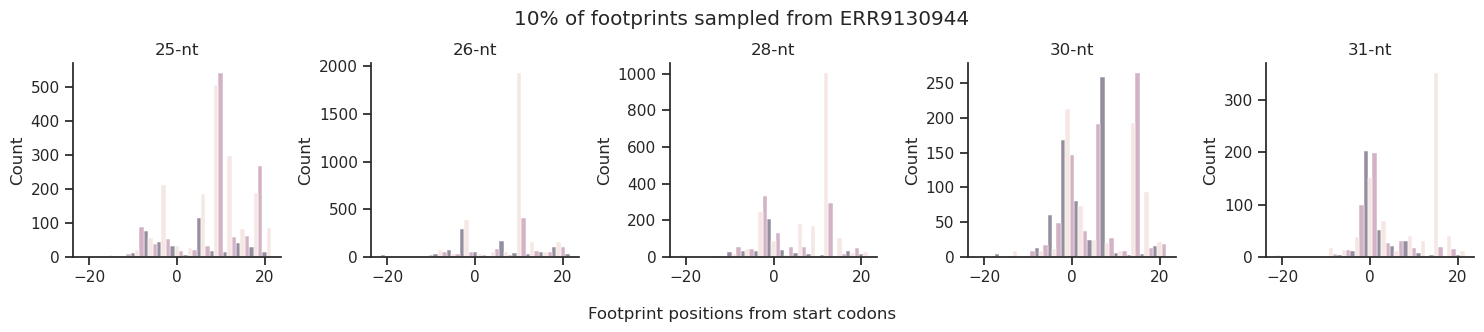

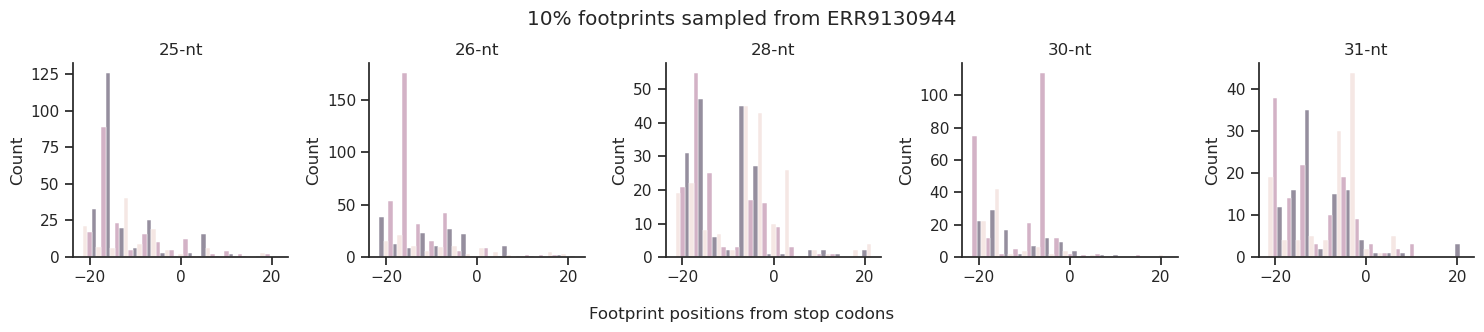

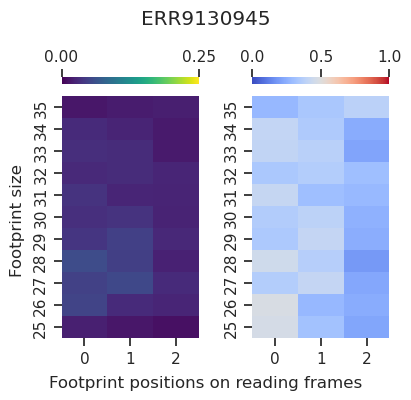

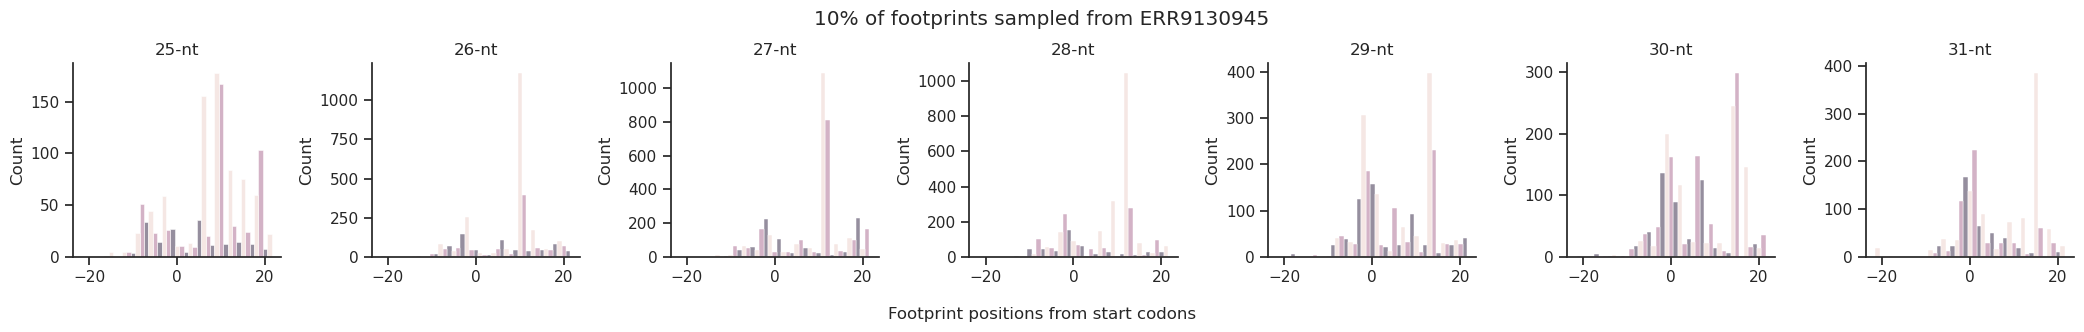

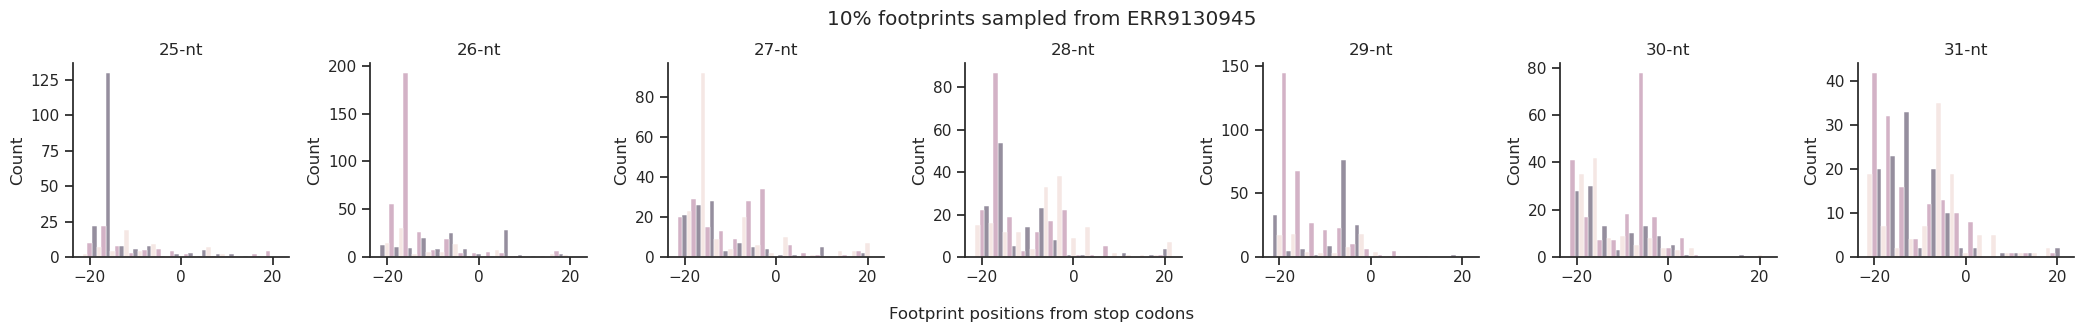

In [5]:
import os
from glob import glob
from riboss.footprints import analyse_footprints

offset_method = '5p'
adj = 12
downsampling = 0.1
outdir = 'results/analyse_footprints'

footprint_stats = []
for i in glob('doc/styphimurium/riboseq/*Aligned.out.bam'):
    stats = analyse_footprints(offset_method, adj, i, downsampling, cds_range, 'good', outdir)
    stats['run'] = os.path.basename(i)
    stats['run'] = stats['run'].str.replace('Aligned.out.bam','')
    footprint_stats.append(stats)

In [6]:
import pandas as pd

filereport = pd.read_csv('doc/styphimurium/riboseq/filereport_read_run_PRJEB51486_tsv.txt', sep='\t')
filereport[['run_accession','sample_title']]

,run_accession,sample_title
0,ERR9130944,RiboSeq S7 1000U
1,ERR9130945,RiboSeq S7 750U
2,ERR9130942,RiboSeq RNase1 1000U
3,ERR9130943,RiboSeq RNase1 500U
4,ERR9130946,RNA-Seq


#### Merge ribosome profiling data and footprint offset files

In [7]:
! samtools merge \
    doc/styphimurium/riboseq/ERR9130942Aligned.out.bam \
    doc/styphimurium/riboseq/ERR9130943Aligned.out.bam \
    -f -o doc/styphimurium/riboseq/ERR9130942_3.bam

#### Build salmon index using transcriptome assembly and run salmon quant

In [8]:
from riboss.wrapper import quantify_transcripts

index = 'doc/metatranscriptome/lt2_puff'
tx_assembly = 'doc/metatranscriptome/lt2.fa'
rnaseq = 'doc/styphimurium/riboseq/ERR9130946.fastq.gz'

quantify_transcripts(rnaseq, tx_assembly, index)

Version Server Response: Not Found
index ["doc/metatranscriptome/lt2_puff_puff"] did not previously exist  . . . creating it
[2024-11-06 17:27:26.837] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2024-11-06 17:27:26.837] [jLog] [info] building index
out : doc/metatranscriptome/lt2_puff_puff
[2024-11-06 17:27:26.838] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers

[2024-11-06 17:27:27.006] [puff::index::jointLog] [warning] Removed 14 transcripts that were sequence duplicates of indexed transcripts.
[2024-11-06 17:27:27.006] [puff::index::jointLog] [warning] If you wish to retain duplicate transcripts, please use the `--keepDuplicates` flag
[2024-11

Threads = 2
Vertex length = 31
Hash functions = 5
Filter size = 134217728
Capacity = 2
Files: 
doc/metatranscriptome/lt2_puff_puff/ref_k31_fixed.fa
--------------------------------------------------------------------------------
Round 0, 0:134217728
Pass	Filling	Filtering
1	0	1	
2	0	0
True junctions count = 4258
False junctions count = 9531
Hash table size = 13789
Candidate marks count = 21363
--------------------------------------------------------------------------------
Reallocating bifurcations time: 0
True marks count: 15780
Edges construction time: 1
--------------------------------------------------------------------------------
Distinct junctions = 4258



TwoPaCo::buildGraphMain:: allocated with scalable_malloc; freeing.
TwoPaCo::buildGraphMain:: Calling scalable_allocation_command(TBBMALLOC_CLEAN_ALL_BUFFERS, 0);
allowedIn: 45
Max Junction ID: 9817
seen.size():78545 kmerInfo.size():9818
approximateContigTotalLength: 3994217
counters for complex kmers:
(prec>1 & succ>1)=23 | (succ>1 & isStart)=1 | (prec>1 & isEnd)=1 | (isStart & isEnd)=2
contig count: 7342 element count: 4793537 complex nodes: 27
# of ones in rank vector: 7341
[2024-11-06 17:27:29.454] [puff::index::jointLog] [info] Starting the Pufferfish indexing by reading the GFA binary file.
[2024-11-06 17:27:29.454] [puff::index::jointLog] [info] Setting the index/BinaryGfa directory doc/metatranscriptome/lt2_puff_puff
size = 4793537
-----------------------------------------
| Loading contigs | Time = 1.6834 ms
-----------------------------------------
size = 4793537
-----------------------------------------
| Loading contig boundaries | Time = 1.2661 ms
--------------------------

for info, total work write each  : 2.331    total work inram from level 3 : 4.322  total work raw : 25.000 
Bitarray        23968384  bits (100.00 %)   (array + ranks )
final hash             0  bits (0.00 %) (nb in final hash 0)


-----------------------------------------
| Loading positions | Time = 16.702 ms
-----------------------------------------
size = 6362317
-----------------------------------------
| Loading reference sequence | Time = 2.0814 ms
-----------------------------------------
-----------------------------------------
| Loading reference accumulative lengths | Time = 38.592 us
-----------------------------------------


INFO:root:saved index to doc/metatranscriptome/lt2_puff_puff/
INFO:root:saved read counts to doc/styphimurium/riboseq/ERR9130946_salmon_quant/


#### Assign footprints to transcripts using riboprof (ribomap)

In [9]:
from riboss.wrapper import riboprofiler

offset = 'results/analyse_footprints/ERR9130942Aligned.out.offset.txt'
ribobam = 'doc/styphimurium/riboseq/ERR9130942_3.bam'
mrnabam = 'doc/styphimurium/riboseq/ERR9130946Aligned.out.bam'
tx_assembly = 'doc/metatranscriptome/lt2.fa'
sf = 'doc/styphimurium/riboseq/ERR9130946_salmon_quant/quant.sf'
out = 'results/riboprofiler/ERR9130942_3'
cds_range_file = 'results/operon_finder/lt2.cds_range.txt'

riboprof_base = riboprofiler(offset, ribobam, mrnabam, 
                             tx_assembly, cds_range_file, 
                             sf, out)

getting transcript info...
total number of transcripts in transcriptome: 4692
assigning ribo-seq reads...
constructing profile class...
number of transcripts in profile class: 3979
loading reads from bam...
getting readlen mapping to P site offset...
getting alignment records...
total number of reads: 16373824
getting read type and p-sites...
total output footprint: 16373824
total: 16373824	multi_mapped: 644818 (3.94 %)
assigning reads to frame 0 loci...
reads used: 4168643 reads assigned: 4168643
assigning reads to frame 1 and 2 loci...
reads used: 6200165 reads assigned: 6200165
assigning reads to UTR loci...
reads used: 6372335 reads assigned: 6372335
assigning RNA-seq reads...
number of transcripts in profile class: 3979
loading reads from bam...
getting alignment records...
total number of reads: 18439875
getting read type and p-sites...
total output footprint: 18439875
total: 18439875	multi_mapped: 1508352 (8.18 %)
assigning reads...
reads used: 18439875 reads assigned: 18439875


INFO:root:saved main output as results/riboprofiler/ERR9130942_3.base


#### Find new ORFs using the main RIBOSS function

parsing ribomap output : 100%|████████████| 3.90k/3.90k [00:00<00:00, 8.80kit/s]
INFO:root:saved ribosome profiles as results/riboss/ERR9130942_3.riboprof.plus.bg and results/riboss/ERR9130942_3.riboprof.minus.bg
counting footprints    : 100%|███████████████| 224k/224k [00:01<00:00, 153kit/s]
comparing periodicity  :  50%|██████▌      | 1.32k/2.64k [03:44<02:00, 10.9it/s]INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
comparing periodicity  :  76%|█████████▊   | 1.99k/2.64k [05:01<00:58, 11.0it/s]INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
comparing periodicity  :  77%|██████████   | 2.04k/2.64k [05:07<01:02, 9.65it/s]INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
INFO:root:[[0.0, 1.0]]
comparing periodicity  :  90%|███████████▋ | 2.38k/2.64k [05:45<00:22, 11.5it/s]INFO:root:[[0.0, 1

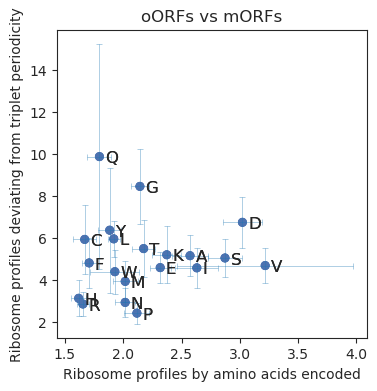

INFO:root:saved scatterplot for anomaly ribosome profiles as results/riboss/ERR9130942_3.riboss.riboprof_aa.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oorfs_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oorfs_no_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.sorfs_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.sorfs_no_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oporfs_blastp_hits.start_codon.pdf
INFO:root:saved metagene plots as results/riboss/ERR9130942_3.riboss.oporfs_no_blastp_hits.start_codon.pdf
INFO:root:saved BLASTP results for RIBOSS hits as results/riboss/ERR9130942_3.riboss.tophits.pkl.gz, results/riboss/ERR9130942_3.riboss.sig.blastp.csv, results/riboss/ERR9130942_3.riboss.sig.blastp.json, and results/riboss/ERR9130942_3.riboss.sig.blastp.pkl.g

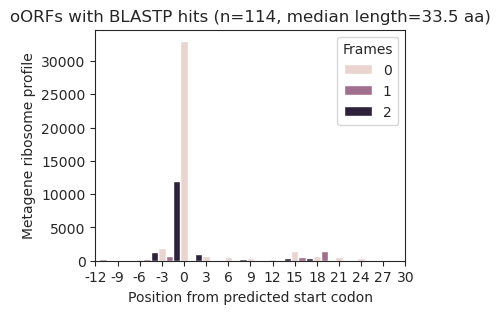

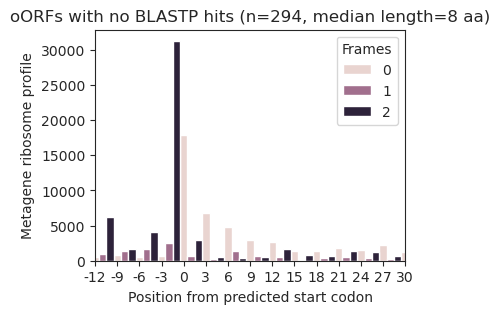

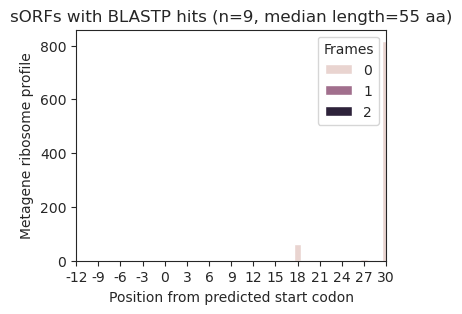

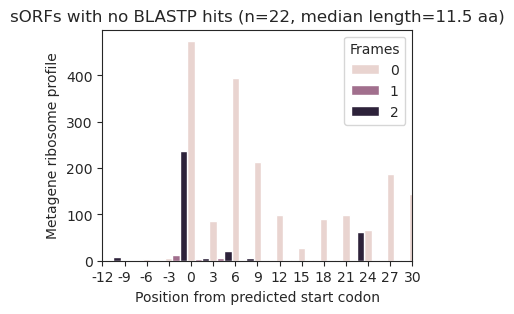

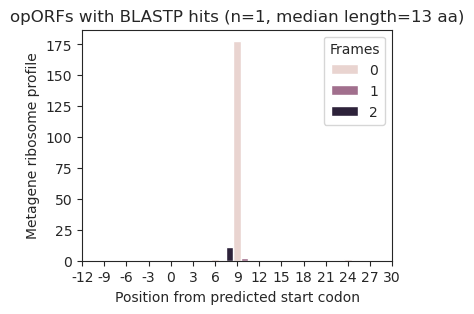

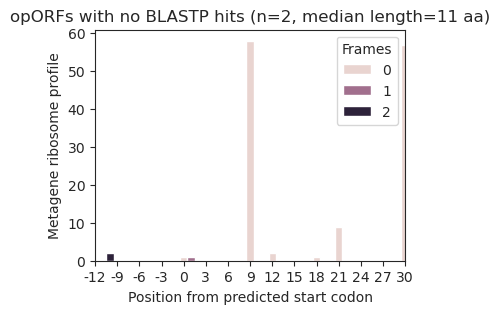

In [2]:
from riboss.riboss import riboss
import pandas as pd

riboprof_base = 'results/riboprofiler/ERR9130942_3.base'
tx_assembly = 'doc/metatranscriptome/lt2.fa'
fasta = 'ref/GCF_000006945.2_ASM694v2_genomic.fna.gz'
bed = 'ref/metagenome.bed'
superkingdom='Bacteria'
outdir = 'results/riboss'
email='chunshen.lim@otago.ac.nz'
api_key='55890b8dfafe4d49e57c5f1d031aec4c2509'

ipg, tophits, blast, sig, boss_df = riboss(superkingdom, df, riboprof_base, tx_assembly, fasta, bed,
                                           tie=False, 
                                           run_blastp=True, run_efetch=True, 
                                           email=email, api_key=api_key, 
                                           delim='::',
                                           outdir=outdir)

#### Visit the [_S_. Typhimurium LT2 genome](https://genome.ucsc.edu/h/GCF_000006945.2) at the UCSC Genome Browser
Click "Manage custom tracks" and submit the tracks below using "Paste URLs or Data".

1. BigGenePred annotation track for predicted sORFs:
```
track type=bigGenePred name="sORFs" description="RIBOSS top hits" baseColorDefault=genomicCodons bigDataUrl=https://github.com/lcscs12345/riboss/raw/refs/heads/master/results/riboss/ERR9130942_3.riboss.sORF.tophits.bb
```

2. BedGraph for ribosome profiles:
```
https://raw.githubusercontent.com/lcscs12345/riboss/refs/heads/master/results/riboss/ERR9130942_3.riboprof.bg
```

3. BED annotation track for transcriptome assembly:
```
https://github.com/lcscs12345/riboss/raw/refs/heads/master/doc/styphimurium/rnaseq/D23005-sc-1962750.sorted.transcripts.bed
```